# TASK 0: LOADING DATA

In [16]:
#Imports
import cv2
import numpy
import glob
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
import scipy.stats as stats
import sys
import csv
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from scipy.spatial.distance import cityblock
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

#Maximise output display size
numpy.set_printoptions(threshold=sys.maxsize)


In [17]:
#FUnction to create dictionary containing Index and corresponding image path
def load_folder(path):
    list_names=[]
    n_images=0                                                            #Number of images in folder
    
    for filename in glob.glob(path):          
        n_images+=1
        list_names.append(filename)
    list_names = natsorted(list_names)                                    #Sort list_names
    
    ID = {}                                                               #Dictionary with Image Index and Image Path.
    i=0
    for imagenames in list_names:
        ID[i] = imagenames
        i+=1
    
    images = numpy.zeros((n_images,64,64))
    k=0

    #Storing image_data in array.
    for filename in list_names:
        images[k] = cv2.imread(filename,0)
        k +=1
        
    images = numpy.true_divide(images,255)                                 # Pixel value range conversion from (0-255) TO (0-1)
    #plt.imshow(images[0], cmap='gray', vmin=0, vmax=1)
    #plt.show()
    
    return n_images,images,list_names,ID


# TASK 1,2: EXTRACTING FEATURES

#### COLOR MOMENTS

In [18]:
# Function to split image from 64*64 to 8*8.
def split_img(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [19]:
#Function to calculate standard deviation (p=2) and skewness (p=3)
def func(p,arr,mean):
    s = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            s += pow((arr[i][j] - mean),p)
    out = s/(len(arr)*len(arr[0]))
    d = 1.0/p
    if(out<0):
        out = abs(out);
        out = pow(out,d)
        out = -1*out
    else:
        out = pow(out,d)
    return out

In [20]:
# Extracting color moments for images.
def c_moment(n_images,images):
    
    #Function call to split images.
    split_images =  numpy.zeros((n_images,64,8,8))
    for i in range(n_images):
        split_images[i] = split_img(images[i], 8, 8)
    
    
    cm_mean = numpy.zeros((n_images,64))
    cm_std_dev = numpy.zeros((n_images,64))
    cm_std_dev_1 = numpy.zeros((n_images,64))
    cm_skew = numpy.zeros((n_images,64))
    cm_vector = numpy.zeros((n_images,64,3))
    
    
    for i in range(len(split_images)):
        for j in range(len(split_images[i])):
            cm_mean[i][j] = numpy.mean(split_images[i][j])
            cm_std_dev[i][j] = func(2,split_images[i][j],cm_mean[i][j])
            cm_skew[i][j] = func(3,split_images[i][j],cm_mean[i][j])
    
    #Combining all features into one feature vector.
    for i in range(len(split_images)):
        for j in range(len(split_images[i])):
            for  k in range(3):
                if (k==0):
                    cm_vector[i][j][k] = cm_mean[i][j]
                elif(k==1):
                    cm_vector[i][j][k] = cm_std_dev[i][j]
                else:
                    cm_vector[i][j][k] = cm_skew[i][j]
    return cm_vector,cm_mean,cm_std_dev,cm_skew


#### LOCAL BINARY PATTERNS

In [21]:
#Function to generate lbp vector for images. 
def elbpattern (n_images,images):
    # settings for LBP
    radius = 1
    n_points = 8
    METHOD = 'uniform'
    
    lbp_v= numpy.zeros((n_images,64,64))
    i=0
    for image in images:
        lbp = local_binary_pattern(image,n_points, radius, METHOD)
        lbp_v[i] = lbp
        i+=1
        #plt.imshow(lbp)
        #plt.show()
    return lbp_v

#### HISTOGRAM OF ORIENTED GRADIENTS

In [22]:
#Function to generate HOG vector for images. 
def hog_feature(images):
    hog_v= numpy.zeros((n_images,3780))
    i=0
    for image in images:
        resized_img = resize(image, (128, 64))
        plt.axis("off")
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), multichannel=False, visualize=False,block_norm='L2-Hys')
        hog_v[i]= fd
        i+=1
    return hog_v

In [23]:
def calculate_features (n_images,images):

    cm_v,cm_mean,cm_std_dev,cm_skew = c_moment(n_images,images)
    #print(cm_v)
    
    lbp_v = elbpattern(n_images,images)
    #print(lbp_v)

    #Function call
    hog_v = hog_feature(images)
    #print(hog_v)
    
    return cm_mean,cm_std_dev,cm_skew,cm_v,lbp_v,hog_v
    
    
    
    

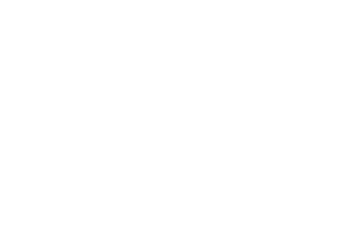

In [35]:
#Input
directory = '/home/shivam/Downloads/images/*.png'                         #Image folder path

#Function call to create dictionary of image names.
n_images,images,list_names,ID = load_folder(directory)
#print(list_names)
#print(ID)

#Function call to calculate features
cm_mean,cm_std_dev,cm_skew,cm_v,lbp_v,hog_v = calculate_features(n_images,images)



In [37]:
#Print output to csv file

f = open('/home/shivam/Downloads/output_Task2.csv', 'w')
header=['Image ID','Image Path','Color Moment Vector','ELBP Vector','HOG Vector']
 
writer = csv.writer(f)
 
writer.writerow(header)
for i in range(n_images):
    dat=[i,ID[i],cm_v[i],lbp_v[i],hog_v[i]]
    writer.writerow(dat)
 

# TASK 3 and TASK 4: 

In [26]:
#NOT USED
#Euclidian distance for Color Moments
def cm_dist_1(x,n_images,cm_mean,cm_std_dev,cm_skew,images):
    
    list_dict = {}

    i=0
    while True:
        dist = numpy.linalg.norm(cm_mean[x] - cm_mean[i]) + numpy.linalg.norm(cm_std_dev[x] - cm_std_dev[i]) + numpy.linalg.norm(cm_skew[x] - cm_skew[i])
        list_dict[i] = dist

        i+=1
        if(i>=n_images):
            break
    return list_dict
    

In [27]:
#Manhattan distance for Color Moments
def cm_dist(x,n_images,cm_mean,cm_std_dev,cm_skew,images):
    
    list_dict = {}
    i=0
    while True:
        dist = cityblock(cm_mean[x], cm_mean[i]) + cityblock(cm_std_dev[x], cm_std_dev[i]) + cityblock(cm_skew[x], cm_skew[i])
        list_dict[i] = dist
        i+=1

        if(i>=n_images):
            break
    return list_dict

In [28]:
#Euclidian distance for ELBP
def eu_dist(x,n_images,lbp_v,images):
    
    list_dict = {}

    i=0
    while True:
        dist = numpy.linalg.norm(lbp_v[x] - lbp_v[i])
        list_dict[i] = dist
        i+=1
        if(i>=n_images):
            break
    return list_dict

In [29]:
#NOT USED
#K-L Divergence For ELBP
def kullback_leibler_divergence(p, q):
    p = numpy.asarray(p)
    q = numpy.asarray(q)
    filt = numpy.logical_and(p != 0, q != 0)
    return numpy.sum(p[filt] * numpy.log2(p[filt] / q[filt]))

#Function to get match images using K-L divergence fucntion
def eu_match(x,n_images,lbp_v,images):
    
    list_dict = {}
    
    best_score = 10
    l = lbp_v[x]
    n_b = int(l.max() + 1)
    hist, _ = numpy.histogram(l, density=True, bins=n_b, range=(0, n_b))
    i=0
    while True:
        lbp = lbp_v[i]
        n_bins = int(lbp.max() + 1)
        ref_hist, _ = numpy.histogram(lbp, density=True, bins=n_b, range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        list_dict[i] = score
        i+=1
        if(i>=n_images):
            break
    return list_dict


In [30]:
#Euclidian Distance for HOG
def h_dist(x,n_images,hog_v,images):
    
    list_dict = {}
    hog_vec = hog_v[x]
    i=0
    while True:
        #print(ID[i])
        dist = numpy.linalg.norm(hog_vec-hog_v[i])
        #print(dist)
        list_dict[i] = dist
        i+=1

        if(i>=n_images):
            break
    return list_dict

In [38]:
def task3_func(model,folder_path,k):                                      # K = NUMBER OF SIMILAR IMAGES REQUIRED. SHOULD BE LESS THAN NO OF IMAGES IN FOLDER.
    n_images,images,list_names,ID = load_folder(folder_path)

    #Function call to calculate features
    cm_mean,cm_std_dev,cm_skew,cm_v,lbp_v,hog_v = calculate_features(n_images,images)
    
    x = 0
    if model == "color_moments":
        list_dict = cm_dist(x,n_images,cm_mean,cm_std_dev,cm_skew,images)
    elif model == "elbp":
        list_dict = eu_dist(x,n_images,lbp_v,images)
    elif model == "hog":
        list_dict = h_dist(x,n_images,hog_v,images)
    else:
        print("NO such feature")
    
    list_dict = sorted(list_dict.items(), key =lambda x: x[1])
    
    #Print Output
    print("The 4 similar images are : ")
    for i in range(k):
        print("Image_ID:", list_dict[i+1][0], "Score: ", (1/(1+(0.1*list_dict[i+1][1])))*100 , "Image path:" , list_names[list_dict[i+1][0]])
                                                                     
                                                                 
                                                                    

The 4 similar images are : 
Image_ID: 6 Score:  39.87889260221019 Image path: /home/shivam/Downloads/set3/image-70.png
Image_ID: 10 Score:  39.75745415813881 Image path: /home/shivam/Downloads/set3/image-110.png
Image_ID: 5 Score:  38.4467425744198 Image path: /home/shivam/Downloads/set3/image-60.png
Image_ID: 8 Score:  37.977200948433484 Image path: /home/shivam/Downloads/set3/image-90.png
------------------------------
The 4 similar images are : 
Image_ID: 6 Score:  5.153845141018746 Image path: /home/shivam/Downloads/set3/image-70.png
Image_ID: 8 Score:  5.153340040974886 Image path: /home/shivam/Downloads/set3/image-90.png
Image_ID: 7 Score:  5.052473562771124 Image path: /home/shivam/Downloads/set3/image-80.png
Image_ID: 10 Score:  5.048674401119299 Image path: /home/shivam/Downloads/set3/image-110.png
------------------------------
The 4 similar images are : 
Image_ID: 10 Score:  57.649982120666046 Image path: /home/shivam/Downloads/set3/image-110.png
Image_ID: 12 Score:  57.2980

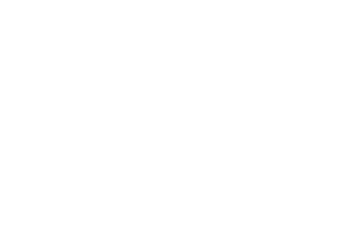

In [39]:
#Print output for Task 3
task3_func("color_moments",'/home/shivam/Downloads/set3/*.png',4)
print("------------------------------")
task3_func("elbp",'/home/shivam/Downloads/set3/*.png',4)
print("------------------------------")
task3_func("hog",'/home/shivam/Downloads/set3/*.png',4)

In [40]:
def task4_func(folder_path,k):                                 # K = NUMBER OF SIMILAR IMAGES REQUIRED. SHOULD BE LESS THAN NO OF IMAGES IN FOLDER.
    
    n_images,images,list_names,ID = load_folder(folder_path)

    #Input
    x = 0

    #Function call to calculate features
    cm_mean,cm_std_dev,cm_skew,cm_v,lbp_v,hog_v = calculate_features(n_images,images)
    
    list_dict_cm = cm_dist(x,n_images,cm_mean,cm_std_dev,cm_skew,images)
    list_dict_lbp = eu_dist(x,n_images,lbp_v,images)
    list_dict_hog = h_dist(x,n_images,hog_v,images)
    
    score_cm = numpy.zeros((n_images))
    score_lbp = numpy.zeros((n_images))
    score_hog= numpy.zeros((n_images))


    for key,value in list_dict_cm.items():
        score_cm[key] = value
    
    for key,value in list_dict_lbp.items():
        score_lbp[key] += value
    
    for key,value in list_dict_hog.items():
        score_hog[key] += value

    # Calculating z scores.
    score_cm_final = stats.zscore(score_cm)
    score_lbp_final = stats.zscore(score_lbp)
    score_hog_final = stats.zscore(score_hog)

    score_final = {}
    
    #Weights
    k1 = 0.2
    k2 = 0.4
    k3 = 0.4
    
    for i in range(n_images):
        score_final[i] = k1*score_cm_final[i] + k2*score_lbp_final[i] + k3*score_hog_final[i]
        
    score_final = sorted(score_final.items(), key =lambda x: x[1])
    
    #Print Output
    for i in range(k):
        print("Image_ID:", score_final[i+1][0], "Score: ", (1/(1+score_final[i+1][1]))*50 , "Image path:" , list_names[score_final[i+1][0]])
                                                              
                                                                 
                                                                    

Image_ID: 10 Score:  50.00552802447651 Image path: /home/shivam/Downloads/set3/image-110.png
Image_ID: 6 Score:  46.05793625221136 Image path: /home/shivam/Downloads/set3/image-70.png
Image_ID: 8 Score:  43.10319159344378 Image path: /home/shivam/Downloads/set3/image-90.png
Image_ID: 9 Score:  40.2046757579851 Image path: /home/shivam/Downloads/set3/image-100.png


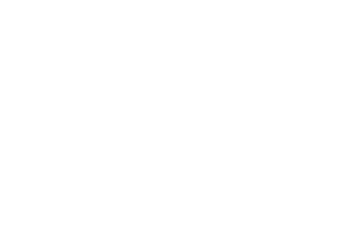

In [41]:
#Print Output for Task 4
task4_func('/home/shivam/Downloads/set3/*.png',4)


In [42]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
